In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-movies-data/imdb-movies-dataset.csv


In [2]:
df = pd.read_csv("/kaggle/input/imdb-movies-data/imdb-movies-dataset.csv")
df.head()

Poster  \
0  https://m.media-amazon.com/images/M/MV5BYWRkZj...   
1  https://m.media-amazon.com/images/M/MV5BZGI4NT...   
2  https://m.media-amazon.com/images/M/MV5BZjIyOT...   
3  https://m.media-amazon.com/images/M/MV5BMjA5Zj...   
4  https://m.media-amazon.com/images/M/MV5BNTk1MT...   

                               Title    Year Certificate  Duration (min)  \
0                    The Idea of You  2023.0           R           115.0   
1  Kingdom of the Planet of the Apes  2023.0       PG-13           145.0   
2                          Unfrosted  2023.0       PG-13            97.0   
3                       The Fall Guy  2023.0       PG-13           126.0   
4                        Challengers  2023.0           R           131.0   

                        Genre  Rating  Metascore           Director  \
0      Comedy, Drama, Romance     6.4       67.0  Michael Showalter   
1   Action, Adventure, Sci-Fi     7.3       66.0           Wes Ball   
2  Biography, Comedy, History     5.5       42.0     Jerry Seinfeld   
3       Action, Comedy, Drama     7.3       73.0       David Leitch   
4       Drama, Romance, Sport     7.7       82.0    Luca Guadagnino   

                                                Cast   Votes  \
0  Anne Hathaway, Nicholas Galitzine, Ella Rubin,...  28,744   
1  Owen Teague, Freya Allan, Kevin Durand, Peter ...  22,248   
2  Isaac Bae, Jerry Seinfeld, Chris Rickett, Rach...  18,401   
3  Ryan Gosling, Emily Blunt, Aaron Taylor-Johnso...  38,953   
4  Zendaya, Mike Faist, Josh O'Connor, Darnell Ap...  32,517   

                                         Description Review Count  \
0  Solène, a 40-year-old single mom, begins an un...          166   
1  Many years after the reign of Caesar, a young ...          183   
2  In 1963 Michigan, business rivals Kellogg's an...          333   
3  A down-and-out stuntman must find the missing ...          384   
4  Tashi, a former tennis prodigy turned coach, t...          194   

                             Review Title  \
0                    Hypocrisy as an idea   
1  A phenomenal start to another trilogy!   
2                               not funny   
3         Everything you needed and more!   
4             Watch "Match Point" instead   

                                              Review  
0  This film, as well as the reaction to it, is a...  
1  I'm a big fan of all the planet of the apes, a...  
2  Pretty much the worst criticism you can lay on...  
3  Just got out of the Austin premier at SXSW and...  
4  This is a tough one. I liked the concept and t...

Already, we can see features that need to be removed, as they don't add anything to EDA or training.
They are: Poster, review title, review, and description. Features that are likely to be removed also include cast and director. However, we can try to obtain certain information from them first. For cast specifically, we can try to obtain rows with certain actor's names in them. Eg: Ryan Gosling.
Note: We can remove title later, when training the model.

In [3]:
df = df.drop('Poster', axis=1).drop('Review Title', axis=1).drop('Review', axis=1)
df = df.drop('Description', axis=1)
df.head()

Title    Year Certificate  Duration (min)  \
0                    The Idea of You  2023.0           R           115.0   
1  Kingdom of the Planet of the Apes  2023.0       PG-13           145.0   
2                          Unfrosted  2023.0       PG-13            97.0   
3                       The Fall Guy  2023.0       PG-13           126.0   
4                        Challengers  2023.0           R           131.0   

                        Genre  Rating  Metascore           Director  \
0      Comedy, Drama, Romance     6.4       67.0  Michael Showalter   
1   Action, Adventure, Sci-Fi     7.3       66.0           Wes Ball   
2  Biography, Comedy, History     5.5       42.0     Jerry Seinfeld   
3       Action, Comedy, Drama     7.3       73.0       David Leitch   
4       Drama, Romance, Sport     7.7       82.0    Luca Guadagnino   

                                                Cast   Votes Review Count  
0  Anne Hathaway, Nicholas Galitzine, Ella Rubin,...  28,744          166  
1  Owen Teague, Freya Allan, Kevin Durand, Peter ...  22,248          183  
2  Isaac Bae, Jerry Seinfeld, Chris Rickett, Rach...  18,401          333  
3  Ryan Gosling, Emily Blunt, Aaron Taylor-Johnso...  38,953          384  
4  Zendaya, Mike Faist, Josh O'Connor, Darnell Ap...  32,517          194

Let's try to use ydata profiling to look at a report of the data.

In [4]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
profile

In [6]:
profile.to_file("report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

We'll need to clean data before doing any sort of preprocessing. The report states that there are missing values, but no duplicate rows.

In [7]:
df = df.dropna()

If we can handle the genre category somehow, then it would improve our model more. We can try to do this using one hot encoding. Based on the dataframe report, there are 22 distinct genres (Single words such as comedy, romance, etc, NOT the combination of words).

In [8]:
# Creating a new feature with the same entries as Genre but in list form
def preprocess_genre(str_genre):
    genre_list = str_genre.split(", ")
    return genre_list

df['Genre List'] = df['Genre'].apply(preprocess_genre)
df.head()

/tmp/ipykernel_18/1534342808.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Genre List'] = df['Genre'].apply(preprocess_genre)


Title    Year Certificate  Duration (min)  \
0                    The Idea of You  2023.0           R           115.0   
1  Kingdom of the Planet of the Apes  2023.0       PG-13           145.0   
2                          Unfrosted  2023.0       PG-13            97.0   
3                       The Fall Guy  2023.0       PG-13           126.0   
4                        Challengers  2023.0           R           131.0   

                        Genre  Rating  Metascore           Director  \
0      Comedy, Drama, Romance     6.4       67.0  Michael Showalter   
1   Action, Adventure, Sci-Fi     7.3       66.0           Wes Ball   
2  Biography, Comedy, History     5.5       42.0     Jerry Seinfeld   
3       Action, Comedy, Drama     7.3       73.0       David Leitch   
4       Drama, Romance, Sport     7.7       82.0    Luca Guadagnino   

                                                Cast   Votes Review Count  \
0  Anne Hathaway, Nicholas Galitzine, Ella Rubin,...  28,744          166   
1  Owen Teague, Freya Allan, Kevin Durand, Peter ...  22,248          183   
2  Isaac Bae, Jerry Seinfeld, Chris Rickett, Rach...  18,401          333   
3  Ryan Gosling, Emily Blunt, Aaron Taylor-Johnso...  38,953          384   
4  Zendaya, Mike Faist, Josh O'Connor, Darnell Ap...  32,517          194   

                     Genre List  
0      [Comedy, Drama, Romance]  
1   [Action, Adventure, Sci-Fi]  
2  [Biography, Comedy, History]  
3       [Action, Comedy, Drama]  
4       [Drama, Romance, Sport]

In [9]:
# Creating a new list of all the unique genres in the df
all_genres = []
for genre_list in df['Genre List']:
    all_genres.extend(genre_list)

unique_genres = set(all_genres)
unique_genres

{'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'Western'}

In [10]:
len(unique_genres)

22

There seem to be 22 unique genres that need to be hot encoded. Since it's not a typical onehot encoding, some features will have a value of 1 at the same time. Obviously, we also need to encode the certificate of the movie using one hot encoding.

In [11]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
#encoded_genres = ohe.fit_transform([genre_list for genre_list in df['Genre List']])
randomlist = [genre_list for genre_list in df['Genre List']]
randomlist[:5]

[['Comedy', 'Drama', 'Romance'],
 ['Action', 'Adventure', 'Sci-Fi'],
 ['Biography', 'Comedy', 'History'],
 ['Action', 'Comedy', 'Drama'],
 ['Drama', 'Romance', 'Sport']]

In [12]:
#encoded_genres = ohe.fit_transform([genre_list for genre_list in df['Genre List']])
#encoded_genres

Unfortuately, onehot encoding failed, due to the fact that there was an unequal number of words in the entries in Genre, leading to inconsistency in feature engineering. Next, we will try TF-IDF vectorization.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
genre_tfidf = vectorizer.fit_transform([genre for genre in df['Genre']])
print(genre_tfidf)

  (0, 18)	0.7363330150254078
  (0, 7)	0.42266592593866964
  (0, 4)	0.5283627598856675
  (1, 10)	0.5779445158964234
  (1, 19)	0.5779445158964234
  (1, 1)	0.42913450242635054
  (1, 0)	0.38445266538
  (2, 12)	0.7346187344744458
  (2, 3)	0.5871359794353599
  (2, 4)	0.340009788993853
  (3, 0)	0.6600764587152541
  (3, 7)	0.4692534954828983
  (3, 4)	0.5866005673599465
  (4, 20)	0.8197884465914964
  (4, 18)	0.4966595286699803
  (4, 7)	0.28508983744850414
  (5, 21)	0.6696846201299321
  (5, 13)	0.7426456150556795
  (6, 21)	0.6205866111859062
  (6, 1)	0.584040314374057
  (6, 0)	0.5232295568893692
  (7, 18)	0.8124735161504983
  (7, 4)	0.5829981008151279
  (8, 22)	0.8728627136858229
  (8, 0)	0.3977085648392453
  :	:
  (6404, 5)	0.5987375680209054
  (6404, 21)	0.6123454660230335
  (6404, 0)	0.5162812749668978
  (6405, 18)	0.7363330150254078
  (6405, 7)	0.42266592593866964
  (6405, 4)	0.5283627598856675
  (6406, 9)	0.7770274711248025
  (6406, 0)	0.51303648799894
  (6406, 7)	0.36472163508504335
  (640

TF-IDF Vectorization seems to have worked. What remains to be seen is how to interpret the data, as it is useless if we can't feed it into the model.

In [14]:
df.describe()

Year  Duration (min)       Rating    Metascore
count  6413.000000     6413.000000  6413.000000  6413.000000
mean   2006.288632      110.052550     6.548994    57.380789
std      18.279006       19.472253     0.937991    17.628859
min    1929.000000       55.000000     1.900000     1.000000
25%    1997.000000       97.000000     6.000000    45.000000
50%    2012.000000      107.000000     6.600000    58.000000
75%    2021.000000      119.000000     7.200000    70.000000
max    2025.000000      321.000000     9.300000   100.000000

We will now convert the matrix into a format such that we can use it in the model.

In [15]:
feature_names = vectorizer.get_feature_names_out()
feature_names

array(['action', 'adventure', 'animation', 'biography', 'comedy', 'crime',
       'documentary', 'drama', 'family', 'fantasy', 'fi', 'film',
       'history', 'horror', 'music', 'musical', 'mystery', 'noir',
       'romance', 'sci', 'sport', 'thriller', 'war', 'western'],
      dtype=object)

In [16]:
genre_tfidf_dense = genre_tfidf.toarray()
for i, feature_name in enumerate(feature_names):
    df[feature_name] = genre_tfidf_dense[:, i]
df.head()

/tmp/ipykernel_18/1027195579.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature_name] = genre_tfidf_dense[:, i]
/tmp/ipykernel_18/1027195579.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature_name] = genre_tfidf_dense[:, i]
/tmp/ipykernel_18/1027195579.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Title    Year Certificate  Duration (min)  \
0                    The Idea of You  2023.0           R           115.0   
1  Kingdom of the Planet of the Apes  2023.0       PG-13           145.0   
2                          Unfrosted  2023.0       PG-13            97.0   
3                       The Fall Guy  2023.0       PG-13           126.0   
4                        Challengers  2023.0           R           131.0   

                        Genre  Rating  Metascore           Director  \
0      Comedy, Drama, Romance     6.4       67.0  Michael Showalter   
1   Action, Adventure, Sci-Fi     7.3       66.0           Wes Ball   
2  Biography, Comedy, History     5.5       42.0     Jerry Seinfeld   
3       Action, Comedy, Drama     7.3       73.0       David Leitch   
4       Drama, Romance, Sport     7.7       82.0    Luca Guadagnino   

                                                Cast   Votes  ... music  \
0  Anne Hathaway, Nicholas Galitzine, Ella Rubin,...  28,744  ...   0.0   
1  Owen Teague, Freya Allan, Kevin Durand, Peter ...  22,248  ...   0.0   
2  Isaac Bae, Jerry Seinfeld, Chris Rickett, Rach...  18,401  ...   0.0   
3  Ryan Gosling, Emily Blunt, Aaron Taylor-Johnso...  38,953  ...   0.0   
4  Zendaya, Mike Faist, Josh O'Connor, Darnell Ap...  32,517  ...   0.0   

  musical  mystery  noir   romance       sci     sport  thriller  war  western  
0     0.0      0.0   0.0  0.736333  0.000000  0.000000       0.0  0.0      0.0  
1     0.0      0.0   0.0  0.000000  0.577945  0.000000       0.0  0.0      0.0  
2     0.0      0.0   0.0  0.000000  0.000000  0.000000       0.0  0.0      0.0  
3     0.0      0.0   0.0  0.000000  0.000000  0.000000       0.0  0.0      0.0  
4     0.0      0.0   0.0  0.496660  0.000000  0.819788       0.0  0.0      0.0  

[5 rows x 36 columns]

We were able to convert the genre information to features via TF-IDF vectorization, thus successfully isolating each individual genre tag, as opposed to label encoding each individual genre category separately, which would introduce way too many features and make the model fall under the curse of dimensionality. Now, the next step is to do a bit more visualisation to check for the correlation between continuous variables, in order to see if it's required to remove any. From the earlier report, it doesn't seem like we have to, but it's good to verify.

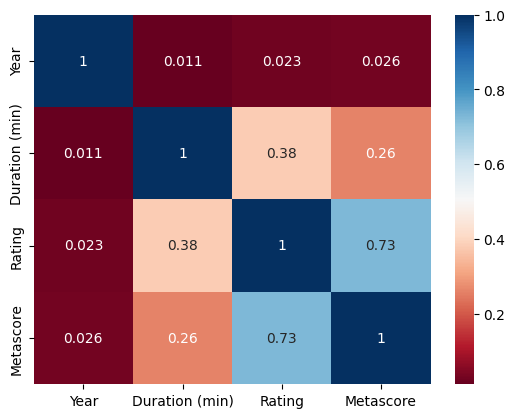

In [17]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

df_heatmap = df[['Year', 'Duration (min)', 'Rating', 'Metascore']]
sns.heatmap(df_heatmap.corr(), annot=True, cmap="RdBu")
plt.show()

As we can see, Rating and Metascore are decently correlated. However, there doesn't seem to be strong correlations between any of the dependent variables. Next, we must investigate the boxplots of continuous variables for outliers. This is to investigate how we must handle them.

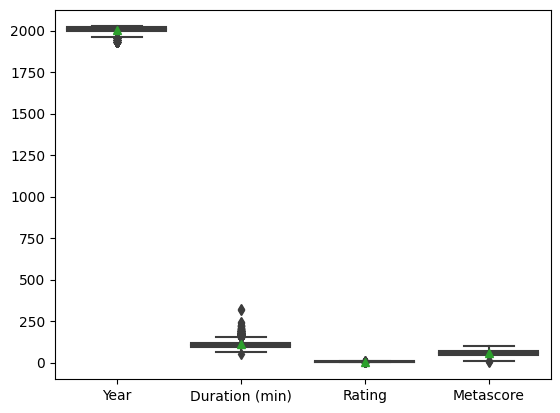

In [18]:
sns.boxplot(df_heatmap, showmeans=True, showfliers=True)
plt.show()

The above graph is awkwardly designed, but still helps us get a picture of the presence of outliers. Year has outliers, but due to the nature of the data, outliers in year doesn't really matter. Metascore hs very few outliers, and they're not that important. Durating seems to have a lot, so it might be good to investigate in greater detail.

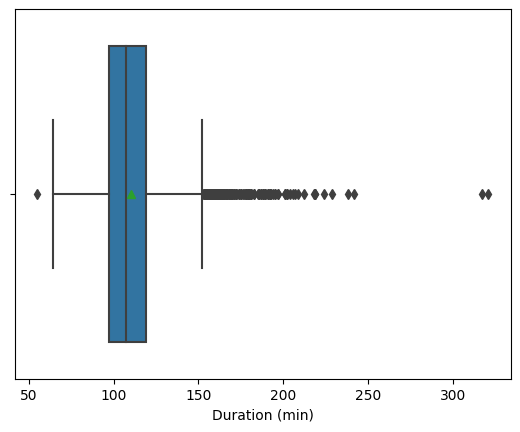

In [19]:
sns.boxplot(x=df['Duration (min)'], showmeans=True, showfliers=True)
plt.show()

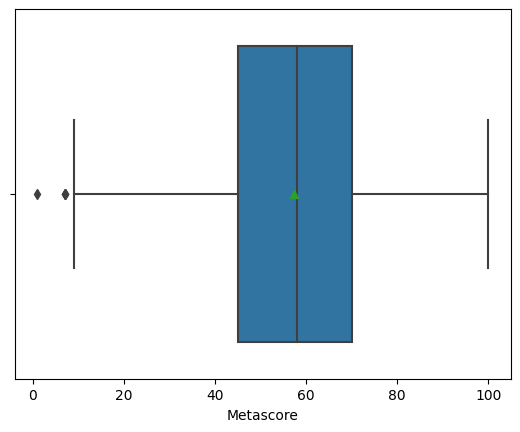

In [20]:
sns.boxplot(x=df['Metascore'], showmeans=True, showfliers=True)
plt.show()

Based on the boxplot, there are a lot of outliers for duration, and nearly none for metascore. Therefore, transformation of duration data is necessary. Since the skew for duration is largely towards the left, we'll need to use box-cox transformation.

In [21]:
from sklearn.preprocessing import PowerTransformer

df['Boxcox duration'] = PowerTransformer('box-cox').fit_transform(df[['Duration (min)']])
df.head()



/tmp/ipykernel_18/899582434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Boxcox duration'] = PowerTransformer('box-cox').fit_transform(df[['Duration (min)']])


Title    Year Certificate  Duration (min)  \
0                    The Idea of You  2023.0           R           115.0   
1  Kingdom of the Planet of the Apes  2023.0       PG-13           145.0   
2                          Unfrosted  2023.0       PG-13            97.0   
3                       The Fall Guy  2023.0       PG-13           126.0   
4                        Challengers  2023.0           R           131.0   

                        Genre  Rating  Metascore           Director  \
0      Comedy, Drama, Romance     6.4       67.0  Michael Showalter   
1   Action, Adventure, Sci-Fi     7.3       66.0           Wes Ball   
2  Biography, Comedy, History     5.5       42.0     Jerry Seinfeld   
3       Action, Comedy, Drama     7.3       73.0       David Leitch   
4       Drama, Romance, Sport     7.7       82.0    Luca Guadagnino   

                                                Cast   Votes  ... musical  \
0  Anne Hathaway, Nicholas Galitzine, Ella Rubin,...  28,744  ...     0.0   
1  Owen Teague, Freya Allan, Kevin Durand, Peter ...  22,248  ...     0.0   
2  Isaac Bae, Jerry Seinfeld, Chris Rickett, Rach...  18,401  ...     0.0   
3  Ryan Gosling, Emily Blunt, Aaron Taylor-Johnso...  38,953  ...     0.0   
4  Zendaya, Mike Faist, Josh O'Connor, Darnell Ap...  32,517  ...     0.0   

  mystery  noir   romance       sci     sport  thriller  war  western  \
0     0.0   0.0  0.736333  0.000000  0.000000       0.0  0.0      0.0   
1     0.0   0.0  0.000000  0.577945  0.000000       0.0  0.0      0.0   
2     0.0   0.0  0.000000  0.000000  0.000000       0.0  0.0      0.0   
3     0.0   0.0  0.000000  0.000000  0.000000       0.0  0.0      0.0   
4     0.0   0.0  0.496660  0.000000  0.819788       0.0  0.0      0.0   

   Boxcox duration  
0         0.458503  
1         1.642247  
2        -0.662052  
3         0.967016  
4         1.166335  

[5 rows x 37 columns]

Lastly, something strange is that in the votes feature, although the data is meant to be numerical, it is actually text. We need to convert this.

In [22]:
df['Votes'] = df['Votes'].replace(',','', regex=True)
df['Votes'] = pd.to_numeric(df['Votes'], errors='coerce')
df['Review Count'] = df['Review Count'].replace(',', '', regex=True)
df['Review Count'] = pd.to_numeric(df['Review Count'], errors='coerce')
df = df.dropna()
df.head()

/tmp/ipykernel_18/68422975.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Votes'] = df['Votes'].replace(',','', regex=True)
/tmp/ipykernel_18/68422975.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Votes'] = pd.to_numeric(df['Votes'], errors='coerce')
/tmp/ipykernel_18/68422975.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

Title    Year Certificate  Duration (min)  \
0                    The Idea of You  2023.0           R           115.0   
1  Kingdom of the Planet of the Apes  2023.0       PG-13           145.0   
2                          Unfrosted  2023.0       PG-13            97.0   
3                       The Fall Guy  2023.0       PG-13           126.0   
4                        Challengers  2023.0           R           131.0   

                        Genre  Rating  Metascore           Director  \
0      Comedy, Drama, Romance     6.4       67.0  Michael Showalter   
1   Action, Adventure, Sci-Fi     7.3       66.0           Wes Ball   
2  Biography, Comedy, History     5.5       42.0     Jerry Seinfeld   
3       Action, Comedy, Drama     7.3       73.0       David Leitch   
4       Drama, Romance, Sport     7.7       82.0    Luca Guadagnino   

                                                Cast  Votes  ...  musical  \
0  Anne Hathaway, Nicholas Galitzine, Ella Rubin,...  28744  ...      0.0   
1  Owen Teague, Freya Allan, Kevin Durand, Peter ...  22248  ...      0.0   
2  Isaac Bae, Jerry Seinfeld, Chris Rickett, Rach...  18401  ...      0.0   
3  Ryan Gosling, Emily Blunt, Aaron Taylor-Johnso...  38953  ...      0.0   
4  Zendaya, Mike Faist, Josh O'Connor, Darnell Ap...  32517  ...      0.0   

  mystery  noir   romance       sci     sport  thriller  war  western  \
0     0.0   0.0  0.736333  0.000000  0.000000       0.0  0.0      0.0   
1     0.0   0.0  0.000000  0.577945  0.000000       0.0  0.0      0.0   
2     0.0   0.0  0.000000  0.000000  0.000000       0.0  0.0      0.0   
3     0.0   0.0  0.000000  0.000000  0.000000       0.0  0.0      0.0   
4     0.0   0.0  0.496660  0.000000  0.819788       0.0  0.0      0.0   

   Boxcox duration  
0         0.458503  
1         1.642247  
2        -0.662052  
3         0.967016  
4         1.166335  

[5 rows x 37 columns]

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6413 entries, 0 to 9998
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            6413 non-null   object 
 1   Year             6413 non-null   float64
 2   Certificate      6413 non-null   object 
 3   Duration (min)   6413 non-null   float64
 4   Genre            6413 non-null   object 
 5   Rating           6413 non-null   float64
 6   Metascore        6413 non-null   float64
 7   Director         6413 non-null   object 
 8   Cast             6413 non-null   object 
 9   Votes            6413 non-null   int64  
 10  Review Count     6413 non-null   int64  
 11  Genre List       6413 non-null   object 
 12  action           6413 non-null   float64
 13  adventure        6413 non-null   float64
 14  animation        6413 non-null   float64
 15  biography        6413 non-null   float64
 16  comedy           6413 non-null   float64
 17  crime            64

As we can see, the votes has successfully been transformed from string to int. Now, transformation is done, so all that's left is final preprocessing before we move onto training.

In [24]:
# Removing unneeded features: Title, genre, director, cast, genre list
# duration(min)

df = df.drop('Title', axis=1).drop('Genre', axis=1).drop('Director', axis=1)
df = df.drop('Cast', axis=1).drop('Genre List', axis=1)
df = df.drop('Duration (min)', axis=1)




In [25]:
# Onehot encoding Certificate
cert_array = ohe.fit_transform(df[['Certificate']])
cert_names = ohe.get_feature_names_out()
cert_df = pd.DataFrame(cert_array, columns=cert_names)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [26]:
df = pd.concat([df, cert_df], axis=1)
df.head()

Year Certificate  Rating  Metascore    Votes  Review Count    action  \
0  2023.0           R     6.4       67.0  28744.0         166.0  0.000000   
1  2023.0       PG-13     7.3       66.0  22248.0         183.0  0.384453   
2  2023.0       PG-13     5.5       42.0  18401.0         333.0  0.000000   
3  2023.0       PG-13     7.3       73.0  38953.0         384.0  0.660076   
4  2023.0           R     7.7       82.0  32517.0         194.0  0.000000   

   adventure  animation  biography  ...  Certificate_PG-13  Certificate_R  \
0   0.000000        0.0   0.000000  ...                0.0            1.0   
1   0.429135        0.0   0.000000  ...                1.0            0.0   
2   0.000000        0.0   0.587136  ...                1.0            0.0   
3   0.000000        0.0   0.000000  ...                1.0            0.0   
4   0.000000        0.0   0.000000  ...                0.0            1.0   

   Certificate_U  Certificate_U/A  Certificate_U/A 16+  Certificate_UA  \
0            0.0              0.0                  0.0             0.0   
1            0.0              0.0                  0.0             0.0   
2            0.0              0.0                  0.0             0.0   
3            0.0              0.0                  0.0             0.0   
4            0.0              0.0                  0.0             0.0   

   Certificate_UA 13+  Certificate_UA 16+  Certificate_UA 7+  \
0                 0.0                 0.0                0.0   
1                 0.0                 0.0                0.0   
2                 0.0                 0.0                0.0   
3                 0.0                 0.0                0.0   
4                 0.0                 0.0                0.0   

   Certificate_Unrated  
0                  0.0  
1                  0.0  
2                  0.0  
3                  0.0  
4                  0.0  

[5 rows x 58 columns]

In [27]:
df = df.drop('Certificate', axis=1)
df.head()

Year  Rating  Metascore    Votes  Review Count    action  adventure  \
0  2023.0     6.4       67.0  28744.0         166.0  0.000000   0.000000   
1  2023.0     7.3       66.0  22248.0         183.0  0.384453   0.429135   
2  2023.0     5.5       42.0  18401.0         333.0  0.000000   0.000000   
3  2023.0     7.3       73.0  38953.0         384.0  0.660076   0.000000   
4  2023.0     7.7       82.0  32517.0         194.0  0.000000   0.000000   

   animation  biography    comedy  ...  Certificate_PG-13  Certificate_R  \
0        0.0   0.000000  0.528363  ...                0.0            1.0   
1        0.0   0.000000  0.000000  ...                1.0            0.0   
2        0.0   0.587136  0.340010  ...                1.0            0.0   
3        0.0   0.000000  0.586601  ...                1.0            0.0   
4        0.0   0.000000  0.000000  ...                0.0            1.0   

   Certificate_U  Certificate_U/A  Certificate_U/A 16+  Certificate_UA  \
0            0.0              0.0                  0.0             0.0   
1            0.0              0.0                  0.0             0.0   
2            0.0              0.0                  0.0             0.0   
3            0.0              0.0                  0.0             0.0   
4            0.0              0.0                  0.0             0.0   

   Certificate_UA 13+  Certificate_UA 16+  Certificate_UA 7+  \
0                 0.0                 0.0                0.0   
1                 0.0                 0.0                0.0   
2                 0.0                 0.0                0.0   
3                 0.0                 0.0                0.0   
4                 0.0                 0.0                0.0   

   Certificate_Unrated  
0                  0.0  
1                  0.0  
2                  0.0  
3                  0.0  
4                  0.0  

[5 rows x 57 columns]

Now it is time to train the model. We will use GridSearchCV to find the best model with the best parameters. Based on that we will choose the model to train.

In [28]:
# Importing libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
df = df.dropna()

X = df.drop('Metascore', axis=1)
y = df['Metascore']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state=42)
kfold = KFold(n_splits=10, shuffle=False)




# Huge dictionary of model hyperparameters
model_params = {
    'random_forest': {
        'model': RandomForestRegressor(random_state=0),
        'params': {
            'n_estimators': [95, 96, 97, 98, 99, 100],
            'max_depth': [13, 14, 15, 16],
            'max_features': [31, 33, 35, 37]
        }
    },
    'decision_tree': {
        'model': DecisionTreeRegressor(random_state=0),
        'params': {
            'splitter': ['best'],
            'max_depth': [13, 14, 15, 16, 17],
            'max_features': [30, 31, 32, 33, 34, 35, 36]
        }
    },
    'lasso': {
        'model': Lasso(random_state=0),
        'params': {
            'alpha': [0.5, 1, 1.5, 2]
        }
    },
    'ridge': {
        'model': Ridge(random_state=0),
        'params': {
            'alpha': [0.5, 1, 1.5, 2]
        }
    },
    'svr': {
        'model': SVR(),
        'params': {
            'kernel': ['sigmoid', 'rbf', 'poly'],
            'gamma': ['scale', 'auto'],
            'C': [0.5, 1.0, 1.5, 2],
            'epsilon': [0.1, 0.2, 0.3, 0.4, 0.5]
        }
    }
}

scores = []

for model, model_parameters in model_params.items():
    clf = GridSearchCV(model_parameters['model'], model_parameters['params'],
                      cv=10, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model,
        'best score': clf.best_score_,
        'best params': clf.best_params_
    })

scores_df = pd.DataFrame(scores)
print(scores_df)

In [29]:
ols = LinearRegression()
ridge = Ridge(alpha=0.5, random_state=0)
lasso = Lasso(alpha=0.5, random_state=0)
decision_tree = DecisionTreeRegressor(max_depth=13, max_features=30, 
                                      splitter='best',
                                      random_state=0)
rfr = RandomForestRegressor(n_estimators=95, max_depth=14,
                            max_features=31)
svr = SVR(C=2, epsilon=0.1, gamma='auto', kernel='rbf')


# Training all the models
ols.fit(X_train, y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)
decision_tree.fit(X_train, y_train)
rfr.fit(X_train, y_train)
svr.fit(X_train, y_train)

SVR(C=2, gamma='auto')

In [30]:
ols_score = ols.score(X_test, y_test)
ridge_score = ridge.score(X_test, y_test)
lasso_score = lasso.score(X_test, y_test)
tree_score = decision_tree.score(X_test, y_test)
rfr_score = rfr.score(X_test, y_test)
svr_score = svr.score(X_test, y_test)

# All the predicted y values
y_pred_ols = ols.predict(X_test)
y_pred_ridge = ridge.predict(X_test)
y_pred_lasso = lasso.predict(X_test)
y_pred_tree = decision_tree.predict(X_test)
y_pred_rfr = rfr.predict(X_test)
y_pred_svr = svr.predict(X_test)

# All the MSEs
mse_ols = mean_squared_error(y_test, y_pred_ols)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mse_tree = mean_squared_error(y_test, y_pred_tree)
mse_rfr = mean_squared_error(y_test, y_pred_rfr)
mse_svr = mean_squared_error(y_test, y_pred_svr)

# All the RMSEs
rmse_ols = np.sqrt(mse_ols)
rmse_ridge = np.sqrt(mse_ridge)
rmse_lasso = np.sqrt(mse_lasso)
rmse_tree = np.sqrt(mse_tree)
rmse_rfr = np.sqrt(mse_rfr)
rmse_svr = np.sqrt(mse_svr)

# All the MAEs
mae_ols = mean_absolute_error(y_test, y_pred_ols)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mae_tree = mean_absolute_error(y_test, y_pred_tree)
mae_rfr = mean_absolute_error(y_test, y_pred_rfr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)

# All KFold scores (based on earlier hyperparameter tuning copy paste)
kfold_ols = cross_val_score(ols, X, y, cv=kfold, scoring='r2').mean()
kfold_ridge = cross_val_score(ridge, X, y, cv=kfold, scoring='r2').mean()
kfold_lasso = cross_val_score(lasso, X, y, cv=kfold, scoring='r2').mean()
kfold_tree = cross_val_score(decision_tree, X, y, cv=kfold, scoring='r2').mean()
kfold_rfr = cross_val_score(rfr, X, y, cv=kfold, scoring='r2').mean()
kfold_svr = cross_val_score(svr, X, y, cv=kfold, scoring='r2').mean()

metrics = {
    'Score': [ols_score, ridge_score, lasso_score, tree_score, rfr_score, svr_score],
    'MSE': [mse_ols, mse_ridge, mse_lasso, mse_tree, mse_rfr, mse_svr],
    'RMSE': [rmse_ols, rmse_ridge, rmse_lasso, rmse_tree, rmse_rfr, rmse_svr],
    'MAE': [mae_ols, mae_ridge, mae_lasso, mae_tree, mae_rfr, mae_svr],
    'KFOLD': [kfold_ols, kfold_ridge, kfold_lasso, kfold_tree, kfold_rfr, kfold_svr]
}

indexes = ['OLS', 'Ridge', 'Lasso', 'Decision Tree', 'RFR', 'SVR']

metrics_df = pd.DataFrame(metrics, index=indexes)
print(metrics_df)

                  Score         MSE       RMSE        MAE     KFOLD
OLS            0.513525  146.565395  12.106420   9.559706  0.511573
Ridge          0.513366  146.613292  12.108398   9.558382  0.511985
Lasso          0.499699  150.730721  12.277244   9.718738  0.499128
Decision Tree  0.212593  237.230089  15.402275  12.171462  0.215259
RFR            0.525800  142.867206  11.952707   9.429348  0.520554
SVR           -0.000464  301.420016  17.361452  14.231441 -0.067436


As we can see, the models don't get a very high regression score, and with testing, if you remove the categorical metrics, they become even more inaccurate. RFR gets the best score on all metrics across the board, but still doesn't perform very well. I think this is because traditional models can't capture semantic meaning behind reviews and descriptions, which are very strong indicators on whether the score will be good or not. Cast is also a strong indicator, with famous actors more likely to get higher movie ratings. 